In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.models import mobilenet_v2 as mb
from torchvision.models import MobileNet_V2_Weights as mb_weight
import torchvision.transforms as transforms

from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd

from tqdm import tqdm
import os
import shutil

default_path = 'E:/2025_KMITL/CODING/SAIG_AI_2/competition'


In [ ]:
####MOVE UNLABELED IMAGE FROM ALL IMAGE FOLDER TO TEST FOLDER

def move_test_image():
    
    image_path = os.path.join(default_path,'train')
    image_des_path = os.path.join(default_path,'test')
    
    df_uuid = pd.read_csv(os.path.join(default_path, 'sample_submission.csv'))['uuid'] + '.png'
    all_image_file = os.listdir(image_path)
    
    unlabel_file = [i for i in df_uuid if i in all_image_file]
    
    for j in unlabel_file:
        shutil.move(os.path.join(image_path, j), os.path.join(image_des_path, j))
    
    

move_test_image()
    

In [31]:
##CHECK FILE
len(os.listdir('E:/2025_KMITL/CODING/SAIG_AI_2/competition/train')), len(os.listdir('E:/2025_KMITL/CODING/SAIG_AI_2/competition/test'))

(6471, 1411)

In [46]:
def split_valid_train(csv_path):
    
    #FILE THINGS
    train_path = os.path.join(default_path, 'train')
    File = pd.read_csv(os.path.join(default_path, csv_path))
    size = 0.2 #20 persent from train folder
    
    os.makedirs(os.path.join(default_path, 'valid'), exist_ok=True)
    valid_path = os.path.join(default_path, 'valid')
    
    train_df, valid_df = train_test_split(File, test_size=size, stratify=File['style'], random_state=42)
    
    valid_imgs = [v + '.png' for v in valid_df['uuid']]
    
    train_df.to_csv('../train.csv', index=False)
    valid_df.to_csv('../valid.csv', index=False)
    
    for i in tqdm(valid_imgs, desc="Moving valid images"):
        if os.path.exists(os.path.join(train_path, i)):
            shutil.move(os.path.join(train_path, i), os.path.join(valid_path, i))    
        else:
            print('nah')

split_valid_train('train.csv')
              

Moving valid images: 100%|██████████| 1295/1295 [00:00<00:00, 15993.94it/s]

nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah


In [37]:
##CHECK FILE
len(os.listdir('E:/2025_KMITL/CODING/SAIG_AI_2/competition/train')), len(os.listdir('E:/2025_KMITL/CODING/SAIG_AI_2/competition/valid')), len(os.listdir('E:/2025_KMITL/CODING/SAIG_AI_2/competition/test'))

(5176, 1295, 1411)

In [38]:
class ImageDataset(Dataset):
    def __init__(self, data_dir, csv_path, transform=None, has_labels = True):
        self.data_dir = data_dir
        self.df = pd.read_csv(csv_path)
        self.transform = transform
        self.has_labels = has_labels
        if self.has_labels:
            self.labels_dic = {label : index for index, label in enumerate(sorted(self.df['style'].dropna().unique()))}
            self.labels_dic['UNK'] = 10
        
            
        
    def __len__(self):
        return len(self.df['uuid'])

    def __getitem__(self, idx):
        
        uuid = self.df.loc[idx, 'uuid']
        image_path = os.path.join(self.data_dir, uuid + '.png') #uuid+.png
        image = Image.open(image_path).convert('RGB')
        style = self.df.loc[idx, 'style']
        
        if self.transform:
            image = self.transform(image)
        
        if self.has_labels:
            style = self.df.loc[idx, 'style']
            if pd.isna(style):
                raise ValueError(f"Missing label at index {idx}")
            label = self.labels_dic[style]
            return image, label
        else:
            return image
    

In [49]:
######################################## TEST ZONE FOR DATASET FUNC #######################
train_dataset = ImageDataset('../train', '../train.csv',has_labels= True)
valid_dataset = ImageDataset('../valid', '../valid.csv',has_labels= True)
test_dataset = ImageDataset('../test', '../sub_dir/submission01.csv', has_labels=False)

7


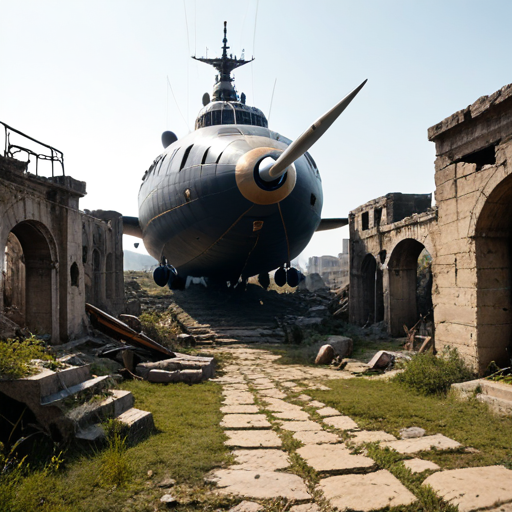

In [50]:
image , label = train_dataset[2]
print(label)
image  

In [ ]:

# OLD STUFF FROM MOBILENET_V2
means = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
transform = transforms.Compose([transforms.Resize(232),
                               transforms.CenterCrop(224),
                               transforms.ToTensor(),
                               transforms.Normalize(mean= means, std=std)])

train_dataset = ImageDataset('../train', '../train.csv', transform, has_labels = True)
valid_dataset = ImageDataset('../valid', '../valid.csv', transform, has_labels = True)
test_dataset = ImageDataset('../test', '../sub_dir/submission01.csv', transform, has_labels = False)

valid_steps = 10 # IDK

In [ ]:
################################ TEST DATASET AFTER TRANSFORM TO TENSOR IMAGE #####################
# image, label = train_dataset[0]

In [ ]:
#LOAD DATA STUFF

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

#THIS SET FOR TESET

In [ ]:
for images, labels in tqdm(train_loader, desc="Loading Train Data"):
    break 

In [ ]:
images.shape, labels.shape, labels

SET UP FOR TRAING LOOP

In [ ]:
weight = mb_weight
model = mb(weights=weight)
model.classifier[1] =nn.Linear(in_features=1280, out_features=11)
print(str(model)[:500])


In [ ]:
####### CHECK ##########
######## IMAGE FORM DATALOADER ######
example = model(images)
example.shape

In [ ]:
# Loss function
criterion = nn.CrossEntropyLoss()
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
##################### CHECK CUDA IN DEVICE ################3
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


###### ###### TRAINING LOOP ###### ###### ❤️❤️❤️❤️❤️❤️❤️❤️❤️ SAIG ❤️❤️❤️❤️❤️❤️

MOBILENET_V2
##epcoh =5 ##
##Epoch 5/5 - Train loss: 0.3678677924861575, Validation loss: 0.47692899825950386##

NEST ซักอย่าง ลืม

In [ ]:
# training loop 
num_epochs = 6
train_losses, val_losses = [], []

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model.to(device)

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc='Training loop'):
        # Move inputs and labels to the device
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)
    
    # Validation phase
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(valid_loader, desc='Validation loop'):
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)
         
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
            
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    val_loss = running_loss / len(valid_loader.dataset)
    val_losses.append(val_loss)
    val_f1 = f1_score(all_labels, all_preds, average='macro')

    print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss}, Validation loss: {val_loss}, F1 Score: {val_f1}")

In [ ]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.title("Loss Curve")
plt.show()

In [ ]:
torch.save(model.state_dict(), ".pth")

In [ ]:
def predict_with_threshold(model, dataloader, threshold=0.6, unk_class_index=10):
    model.eval()
    predictions = []
    with torch.no_grad():
        for images in tqdm(dataloader, desc="Predicting"):
            if isinstance(images, (list, tuple)):
                images = images[0]  # กรณี dataloader ส่ง (image, label)
            images = images.to(device)
            outputs = model(images)
            probs = F.softmax(outputs, dim=1)
            confs, preds = torch.max(probs, dim=1)
            for conf, pred in zip(confs, preds):
                if conf.item() < threshold:
                    predictions.append(unk_class_index)  # เป็น UNK
                else:
                    predictions.append(pred.item())      # class จริง
    return predictions

In [ ]:
preds = predict_with_threshold(model, test_loader, threshold=0.55, unk_class_index=10)

In [ ]:
df = pd.read_csv("submission.csv") 
df["style"] = preds
df.to_csv("submission_with_unk.csv", index=False)

In [ ]:

my_dict = {0: 'Ink scenery',
           1: 'comic',
           2: 'cyberpunk',
           3: 'futuristic UI',
           4: 'lowpoly',
           5: 'oil painting',
           6: 'pixel',
           7: 'realistic',
           8: 'steampunk',
           9: 'water color',
           10: 'UNK'}

def checktest(idx, img_dir, csv_path, dict):
    df_read = pd.read_csv(csv_path)
    uuid = df_read.loc[idx, 'uuid']
    img_path = os.path.join(img_dir, uuid + '.png')
    img = Image.open(img_path).convert('RGB')
    style = dict[df_read.loc[idx, 'style']]
    return img, style
    
img, label = checktest(71, 'Unlabeled_for_test', 'submission01.csv', my_dict)
print(label)
img

In [ ]:
def label_to_style(csvfile):
    df = pd.read_csv(csvfile)
    df['style'] = df['style'].map(my_dict)
    Name = csvfile[:-4] + '_with_style.csv'
    df.to_csv(Name, index=False)

label_to_style('submission01.csv')